# Analyzing out-of-this world data, Part 2
Using data collected from the Open Exoplanet Catalogue database: https://github.com/OpenExoplanetCatalogue/open_exoplanet_catalogue/

## Data License
Copyright (C) 2012 Hanno Rein

Permission is hereby granted, free of charge, to any person obtaining a copy of this database and associated scripts (the "Database"), to deal in the Database without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Database, and to permit persons to whom the Database is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Database. A reference to the Database shall be included in all scientific publications that make use of the Database.

THE DATABASE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE DATABASE OR THE USE OR OTHER DEALINGS IN THE DATABASE.

## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
planets = pd.read_csv('data/planets.csv')

Since we completed our EDA in the [planets_ml.ipynb notebook for last chapter](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/planets_ml.ipynb), we will just look at the first 5 rows to refresh our memory of the data rather than repeating the EDA here.

In [3]:
planets.head()

,period,name,eccentricity,description,discoverymethod,periastrontime,lastupdate,semimajoraxis,mass,periastron,list,discoveryyear
0,326.03,11 Com b,0.231,11 Com b is a brown dwarf-mass companion to th...,RV,2452899.60,15/09/20,1.290,19.400,94.800,Confirmed planets,2008.0
1,516.22,11 UMi b,0.080,11 Ursae Minoris is a star located in the cons...,RV,2452861.04,15/09/20,1.540,11.200,117.630,Confirmed planets,2009.0
2,185.84,14 And b,0.000,14 Andromedae is an evolved star in the conste...,RV,2452861.40,15/09/20,0.830,4.800,0.000,Confirmed planets,2008.0
3,1766.00,14 Her b,0.359,The star 14 Herculis is only 59 light years aw...,RV,NaN,15/09/21,2.864,4.975,22.230,Confirmed planets,2002.0
4,9886.00,14 Her c,0.184,14 Her c is the second companion in the system...,RV,NaN,15/09/21,9.037,7.679,189.076,Controversial,2006.0


## Predicting Length of Year (Period)

In [4]:
from sklearn.model_selection import train_test_split

data = planets[
    ['semimajoraxis', 'period', 'mass', 'eccentricity']
].dropna()
planets_X = data[['semimajoraxis', 'mass', 'eccentricity']]
planets_y = data.period

pl_X_train, pl_X_test, pl_y_train, pl_y_test = train_test_split(
    planets_X, planets_y, test_size=0.25, random_state=0
)

### Hyperparameter Tuning with GridSearchCV

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LinearRegression())
])

search_space = {
    'scale__with_mean' : [True, False], 'scale__with_std' : [True, False],
    'lr__fit_intercept': [True, False], 'lr__normalize' : [True, False]
}
grid = GridSearchCV(
    model_pipeline, search_space, cv=5,
    scoring={
        'r_squared': 'r2', 
        'mse' : 'neg_mean_squared_error', 
        'mae' : 'neg_mean_absolute_error',
        'rmse' : make_scorer(lambda x, y: np.sqrt(mean_squared_error(x, y)))
    }, refit='mae', iid=False
).fit(pl_X_train, pl_y_train)

We can check the best score from the cross validation and the best hyperparameters in the search space:

In [6]:
print('Best parameters (CV score=%.2f):\n%s' % (
    grid.best_score_, grid.best_params_
))

Best parameters (CV score=-1605.54):
{'lr__fit_intercept': False, 'lr__normalize': True, 'scale__with_mean': False, 'scale__with_std': True}


This reduced our MAE by over 150 Earth days ([compared to chapter 9's model](https://github.com/stefmolin/Hands-On-Data-Analysis-with-Pandas/blob/master/ch_09/planets_ml.ipynb)):

In [7]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pl_y_test, grid.predict(pl_X_test))

1235.4924651855556

## Can a decision tree tell us what features are important?

In [8]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0).fit(pl_X_train, pl_y_train)
[(col, coef) for col, coef in zip(
    pl_X_train.columns, dt.feature_importances_
)]

[('semimajoraxis', 0.9909470467126007),
 ('mass', 0.008457963837110774),
 ('eccentricity', 0.0005949894502886271)]

We can visualize the decisions the tree is making:

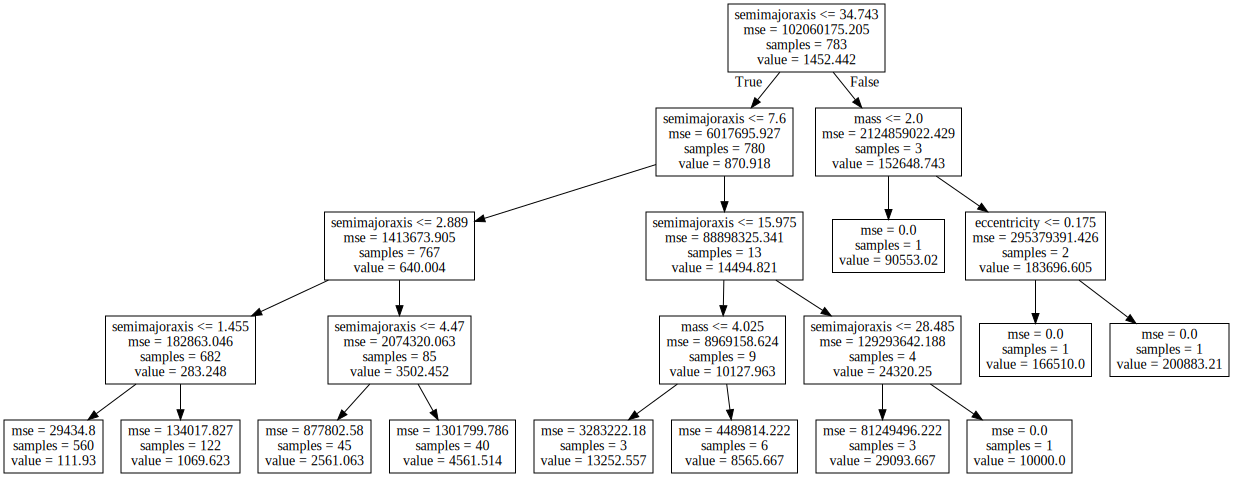

In [9]:
from sklearn.tree import export_graphviz
import graphviz

graphviz.Source(export_graphviz(
    DecisionTreeRegressor(
        max_depth=4, random_state=0
    ).fit(pl_X_train, pl_y_train),
    feature_names=pl_X_train.columns
))

### Regularization
Ridge (L2) and LASSO (L1) are terms we can add to regression to penalize large coefficients. L2 uses squared coefficients and L1 uses the absolute value. LASSO tends to drive coeffiecients to zero and is therefore used for feature selection. We can combine the two in an elastic net. These help to reduce overfitting. Check the documentation for parameters that can be tuned:

In [10]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge, lasso, elastic = Ridge(), Lasso(), ElasticNet()

for model in [ridge, lasso, elastic]:
    model.fit(pl_X_train, pl_y_train)
    print(
        f'{model.__class__.__name__}: '
        f'{model.score(pl_X_test, pl_y_test):.4}'
    )

Ridge: 0.9302
Lasso: 0.9298
ElasticNet: 0.9375
